In [3]:
N = 64
amp = np.sqrt(N)
OB = np.linalg.qr(np.random.randn(N,N))[0]
J0 = getJ(N,1.1)
# J0 = (2*np.random.rand(N,N)-1)/np.sqrt(N)

In [6]:
sl = 3; pl = 6; iSize = pl+1; oSize = pl; batch = 32
pool = np.array([p for p in multiset_permutations(np.arange(pl))]).T
dl = np.prod([i+1 for i in range(pl-sl)])
seq_pool = torch.tensor(pool[:sl,::dl], dtype=torch.long)
spL = seq_pool.shape[1]
sid = torch.randperm(spL)
seq_pool0 = seq_pool[:,sid[spL//4:]]
seq_pool1 = seq_pool[:,sid[:spL//4]]
spl = seq_pool0.shape[1]; spl_ = spL-spl
seq_pools = torch.cat((seq_pool0[:,torch.argsort(sid[spl_:])],seq_pool1[:,torch.argsort(sid[:spl_])]),1)
# seq_pool0 = seq_pool; spl=spL
print(spL,spl,batch)

120 90 32


In [ ]:
class myRNN(nn.Module):
    def __init__(self, iSize, oSize):
        super(myRNN, self).__init__()
        self.a = a; self.b = b; self.sl = sl; self.bs = batch
        self.t_a = t_a; self.t_p = t_p; self.t_p_= t_p//2; self.t_g = t_g
        self.t1 = t_a + sl*t_p; self.t2 = t_a + sl*t_p + t_w
        self.f  = nn.Sigmoid(); self.g = nn.Softmax(dim=1)
        self.J  = nn.Parameter(tt(J0))
        self.W  = nn.Parameter(oB[-oSize:].t())
        self.Ui = nn.Parameter(amp*oB[:iSize-sl])
        self.x0 = nn.Parameter(tt(zr(N)))
        self.bi = nn.Parameter(tt(zr(N)))
        self.bo = nn.Parameter(tt(zr(oSize)))
        self.br = nn.Parameter(tt(np.ones(sl)/amp))
        self.Ur = nn.Parameter(amp*oB[iSize-sl:iSize])

    def forward(self, seq, t_v):
        X = []; x = self.x0.repeat(self.bs,1); u = self.Ur.repeat(self.bs,1,1)
        for _ in range(self.t_a):
            x = (1-self.a)*x + self.a*(self.f(x)@self.J + self.bi); X.append(x)
        for j in range(self.sl):
            I = self.Ui[seq[j,:],:]; u_ = u[:,j,:]
            for _ in range(self.t_p_):
                x = (1-self.a)*x + self.a*(self.f(x)@self.J + self.bi + I); X.append(x)
            for _ in range(self.t_p_):
                x = (1-self.a)*x + self.a*(self.f(x)@self.J + self.bi + I + u_); X.append(x)                
                u_= (1-self.b)*u_+ self.b*(self.Ur[j] + self.br[j]*self.f(x))   
            u = (1-self.b)**self.t_p*(u-self.Ur) + self.Ur; u[:,j,:] = u_            
        for j in range(self.sl):
            for _ in range(t_v[j]-self.t_g):
                x = (1-self.a)*x + self.a*(self.f(x)@self.J + self.bi); X.append(x)
            u = (1-self.b)**(t_v[j]-self.t_g)*(u-self.Ur) + self.Ur; u_ = u[:,j,:]
            for _ in range(self.t_g):
                x = (1-self.a)*x + self.a*(self.f(x)@self.J + self.bi + u_); X.append(x)
                u_= (1-self.b)*u_+ self.b*(self.Ur[j] + self.br[j]*self.f(x))
            u = (1-self.b)**self.t_g*(u-self.Ur) + self.Ur; u[:,j,:] = u_            
        for _ in range(2*self.t_a):
            x = (1-self.a)*x + self.a*(self.f(x)@self.J + self.bi); X.append(x)
        return self.g(self.f(torch.cat(X))@self.W + self.bo).view(-1,self.bs,self.W.shape[1])
    
    def CELoss(self, o, seq, t_v):        
        sum0 = torch.mean(-torch.log(torch.cat((o[:self.t_a,:,-1], o[-self.t_a:,:,-1,]),1)))     
        sum1 = torch.mean(-torch.log(o[self.t1+self.t_g:self.t1+t_v[0]-self.t_g,:,-2]))     
        sum2 = sum(torch.mean(-torch.log(o[self.t1+sum(t_v[:j+1]):self.t2+sum(t_v[:j+1]),range(self.bs),seq[j,:]])) for j in range(self.sl))
        return sum0 + sum1 + 5*sum2

In [166]:
class myRNN(nn.Module):
    def __init__(self, iSize, oSize):
        super(myRNN, self).__init__()
        oB = tt(OB)
        self.a = a
        self.N = N
        self.sl= sl
        self.bs= batch
        self.amp = amp
        self.t_a = t_a
        self.t_p = t_p
        self.t_d = t_d
        self.t_g = t_g
        self.t_go= t_go
        self.f  = nn.Sigmoid() #nn.Softplus()
        self.g  = nn.Softmax(dim=0)
        self.J  = nn.Parameter(tt(J0))
        self.W  = nn.Parameter(oB[-oSize:])
        self.U  = nn.Parameter(oB[:iSize].t())
        self.x0 = nn.Parameter(tt(zr((N,1))))
        self.bi = nn.Parameter(tt(zr((N,1))))
        self.bo = nn.Parameter(tt(zr((oSize,1))))

    def forward(self, seq, t_v, flag=0):
        X = []; x = self.x0.repeat(1,seq.shape[1])
        for _ in range(self.t_a+t_v[0]):
            x = (1-self.a)*x + self.a*(self.J@self.f(x) + self.bi); X.append(x)
        for j in range(self.sl):
            I = self.amp*self.U[:,seq[j,:]]
            for _ in range(t_vp[j]):
                x = (1-self.a)*x + self.a*(self.J@self.f(x) + self.bi + I); X.append(x)
        for _ in range(self.t_d + t_v[1]):
            x = (1-self.a)*x + self.a*(self.J@self.f(x) + self.bi); X.append(x)
        I = self.amp*self.U[:,[-1]]
        for _ in range(self.t_go):
            x = (1-self.a)*x + self.a*(self.J@self.f(x) + self.bi + I); X.append(x)
        for _ in range(self.t_a*(self.sl+1)):
            x = (1-self.a)*x + self.a*(self.J@self.f(x) + self.bi); X.append(x)
        X = torch.cat(X,1)
        O = self.g(self.W@self.f(X) + self.bo)
        if flag==0: return O.view(self.W.shape[0],-1,self.bs)
        else: return O.view(self.W.shape[0],-1,x.shape[1]), X.view(self.N,-1,x.shape[1])
    
    def CELoss(self, o, seq, t_v):
        sum0 = (torch.sum(-torch.log(o[-2,:self.t_a+t_v[0],:]))+torch.sum(-torch.log(o[-2,self.t_g-self.t_a:,:])))/(self.t_a*2+t_v[0]-self.t_g)
        sum1 = torch.sum(-torch.log(o[-1,self.t_a+t_v[0]+self.t_g:-self.t_a*(self.sl+1),:]))/(self.sl*self.t_p+self.t_d+t_v[1]+self.t_go-self.t_g)        
        sum2 = sum(torch.sum(-torch.log(o[seq[self.sl-j-1,range(self.bs)], self.t_g+(j-self.sl-1)*self.t_a:(j-self.sl)*self.t_a, range(self.bs)]))
                   /(self.t_a-self.t_g) for j in range(self.sl))
        return (sum0 + sum1/2 + 10*sum2)/self.bs

In [167]:
a = .1 # dt/tau
t_p = 30; t_d = 30; t_go= 15; t_a = 30; t_g = 15 # grace period

In [168]:
t_v0 = [-10,0,10]; t_v1 = [0,10,30,60]
t_vs = [[x,y] for x in t_v0 for y in t_v1]; ia = len(t_vs)

In [169]:
# rnn = myRNN(iSize, oSize).to(device)
L=[]; epoch = 1; count = 0; n_r = 1024; ip = 64

In [170]:
lr = 1e-3; lam = 1e-5
pas = [{'params': [rnn.J, rnn.W, rnn.bo, rnn.x0]}, 
       {'params': [rnn.U, rnn.bi], 'lr': lr/2}]
opt = optim.Adam(pas, lr=lr, weight_decay=lam)

In [171]:
# opt.param_groups[1]['lr']

In [172]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', .3, n_r/ip, True, 0.01)

In [ ]:
torch.save(rnn, 'rnn_gener_'+str(count))

In [ ]:
epoch = 24
since = time.time()
for e in range(epoch):
    l=[]; count+=1; print(count)
    rid = torch.randint(ia,(n_r,),device=device)
    for i in range(n_r):
        seq = seq_pool0[:,torch.randint(spl,(batch,),device=device)]
        opt.zero_grad(); t_v = t_vs[rid[i]]
        o = rnn(seq,t_v); loss = rnn.CELoss(o,seq,t_v)
        loss.backward(); l.append(loss.item()); opt.step()
        if (i+1)%ip == 0: 
            ml = sum(l[i+1-ip:i+1])/ip; print('loss: %.5f'%ml); scheduler.step(ml)
    L.extend(l)
torch.save(rnn, 'rnn_gene_'+str(count))
time.time() - since

In [414]:
print(np.mean(nm(tn(rnn.U)))); print(np.mean(nm(tn(rnn.W).T))); pEvl2(J0,tn(rnn.J))
pf(20,4); plt.semilogy(L); plt.xlim(0,len(L)); plt.show()

4.936989410840747
17.06006414587347


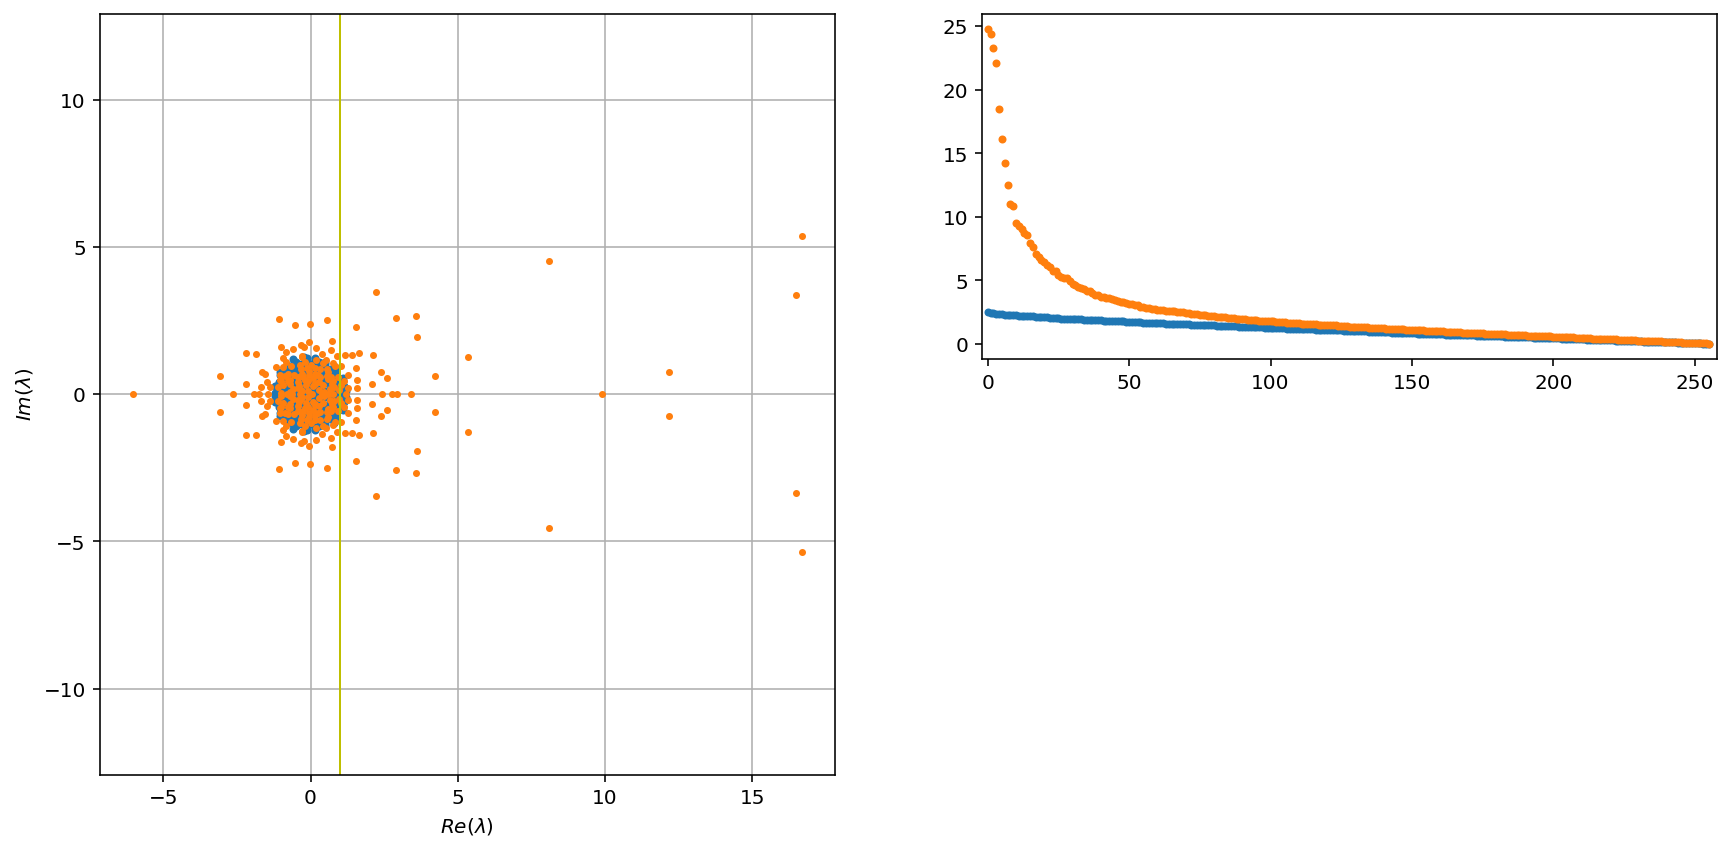

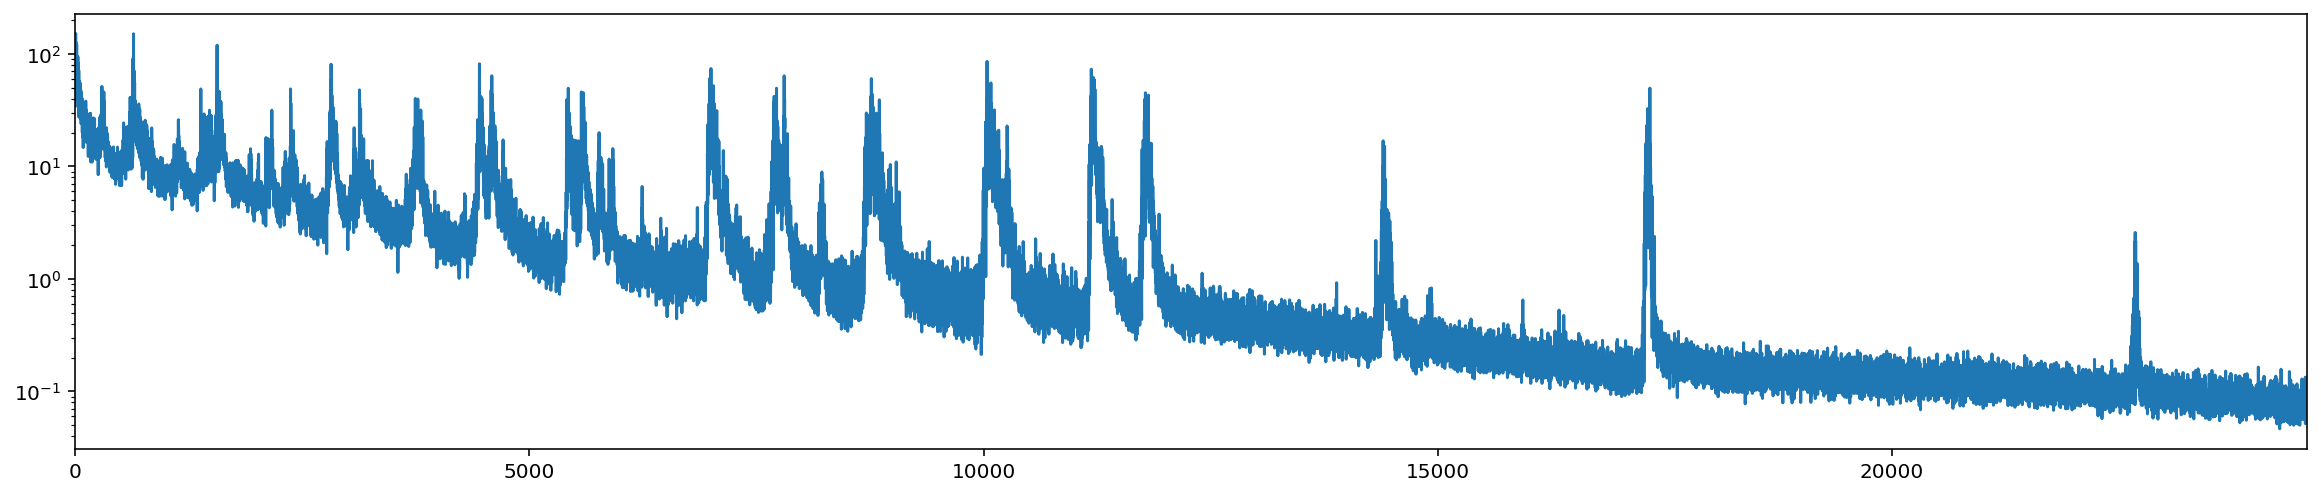

In [525]:
def pRout(Os, seq_p, p=0):
    pf(pw1,ph2); tR = np.arange(1,Os.shape[1]+1); apl = np.arange(pl)
    plt.plot(tR, Os[-2,:],'-.',c='gray'); plt.plot(tR, Os[-1,:],'-.',c='y')
    plt.axvline(t_a+t_p*sl+t_v[0]+t_v[1]+t_d, ls=':',c='r',lw='1')
    plt.axvline(t_a+t_p*sl+t_v[0]+t_v[1]+t_d+t_go, ls=':',c='r',lw='1')
    for i in range(sl+1): plt.axvline(i*t_p+t_a+t_v[0],ls=':',c='k',lw='1')   
    for j in range(sl): plt.axvline(t_p*sl+t_v[0]+t_v[1]+t_d+t_go+t_a*(j+2),ls=':',lw=1,c='g')
    for i in range(sl): 
      color = 'C'+str(seq_p[i].item()); tt = t_v[0]+t_a*(i+1)
      plt.plot(tR,Os[seq_p[i],:], lw=2, c=color)
      if p==1: plt.plot([tt+3,tt+t_a-3],[1.06,1.06],lw=2.5,c=color)
    for j in apl[~np.in1d(apl,seq_p)]: plt.plot(tR,Os[j,:]-.01,ls='--',c='C'+str(j))
    plt.xlim(tR[0],tR[-1]); plt.gca().yaxis.tick_right(); plt.yticks(fontsize=8)

In [569]:
t_v = [0,max(t_v1)-10]; seq_pools = torch.cat((seq_pool0[:,torch.argsort(sid[:spl])],seq_pool1[:,torch.argsort(sid[spl:])]),1)
with torch.set_grad_enabled(False): o, x = rnn(seq_pools, t_v, 1)

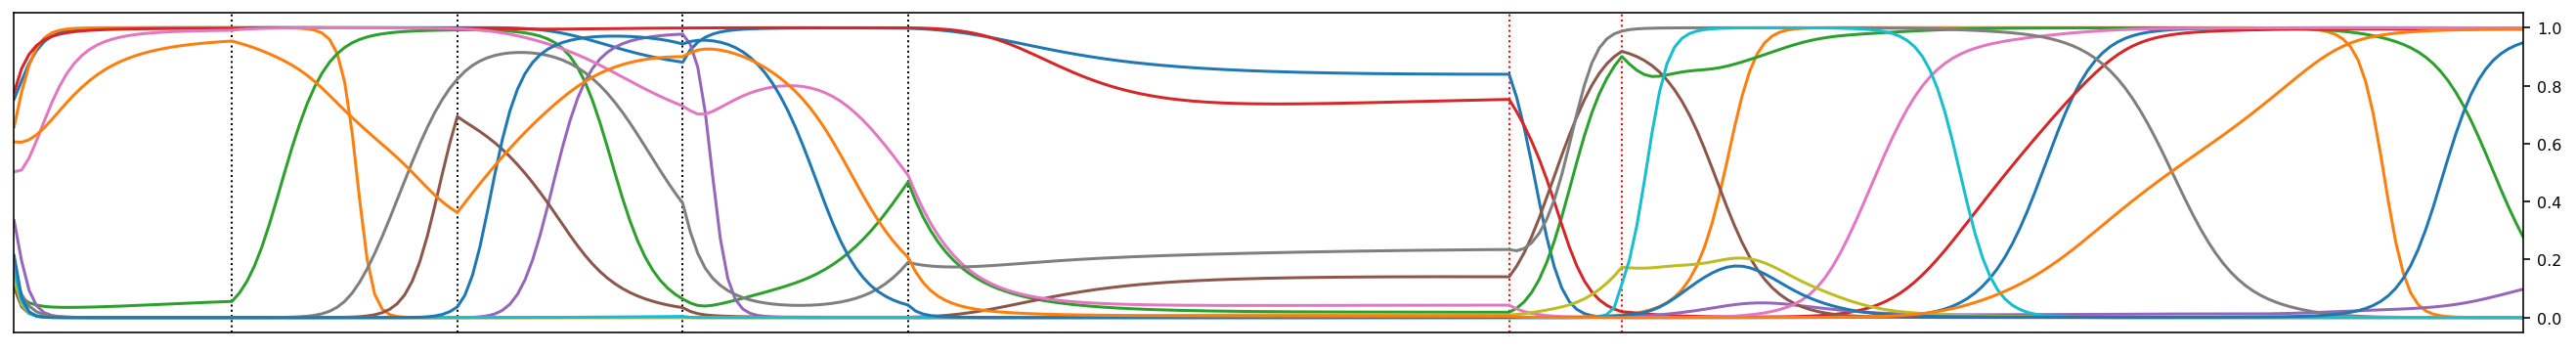

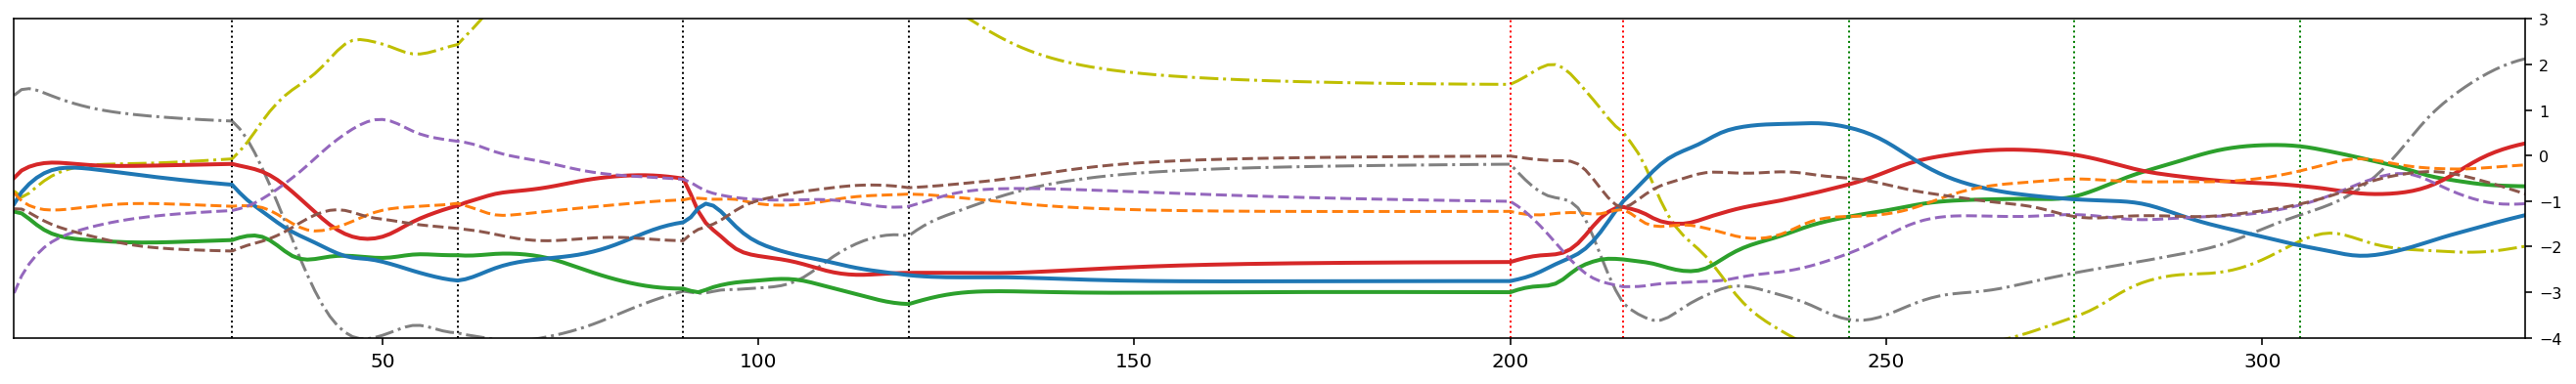

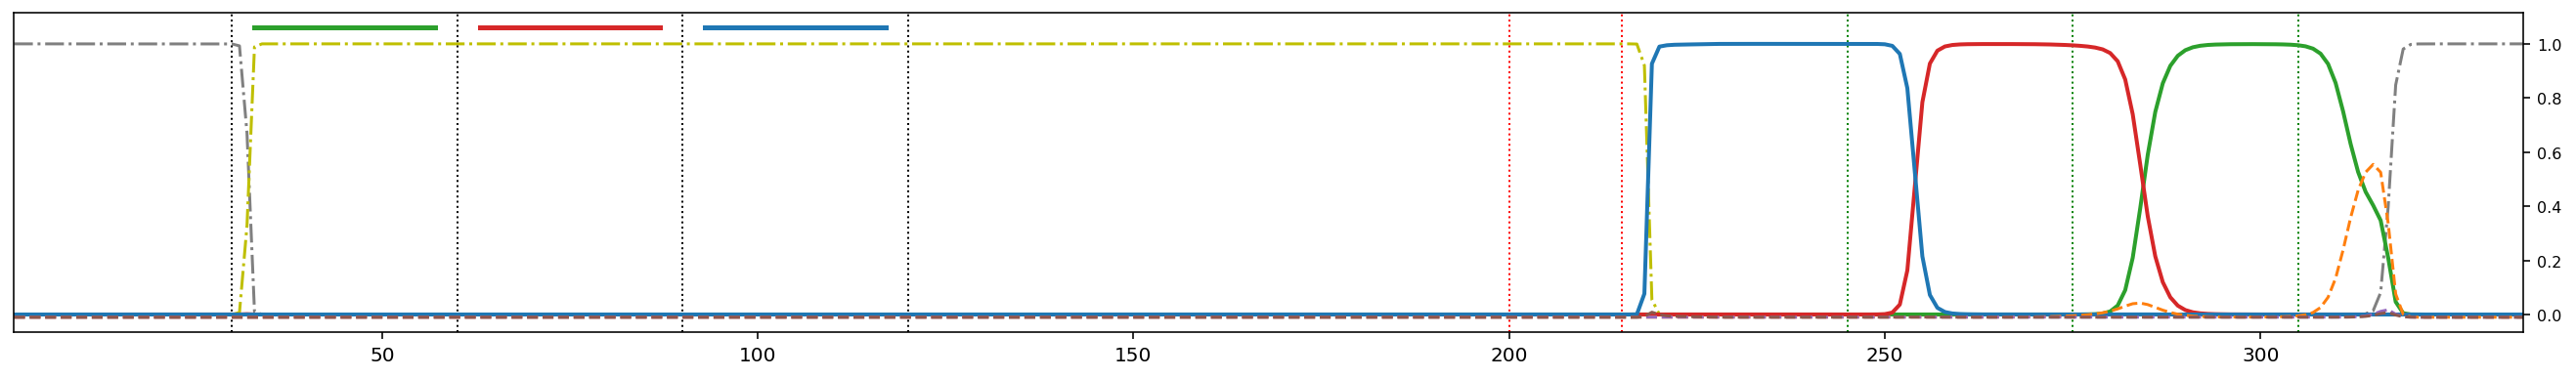

tensor([2, 3, 0]) True


In [573]:
ib = np.random.randint(spl)
seq_p = seq_pools[:,ib]; r = tn(rnn.f(x[:,:,ib])); pAct(r)
W  = tn(rnn.W); bo = tn(rnn.bo); O_ = W@r + bo; pRout(O_/10,seq_p); plt.ylim(-4,3)
pRout(tn(o[:,:,ib]), seq_p, 1); plt.show(); print(seq_p, ib<spl)

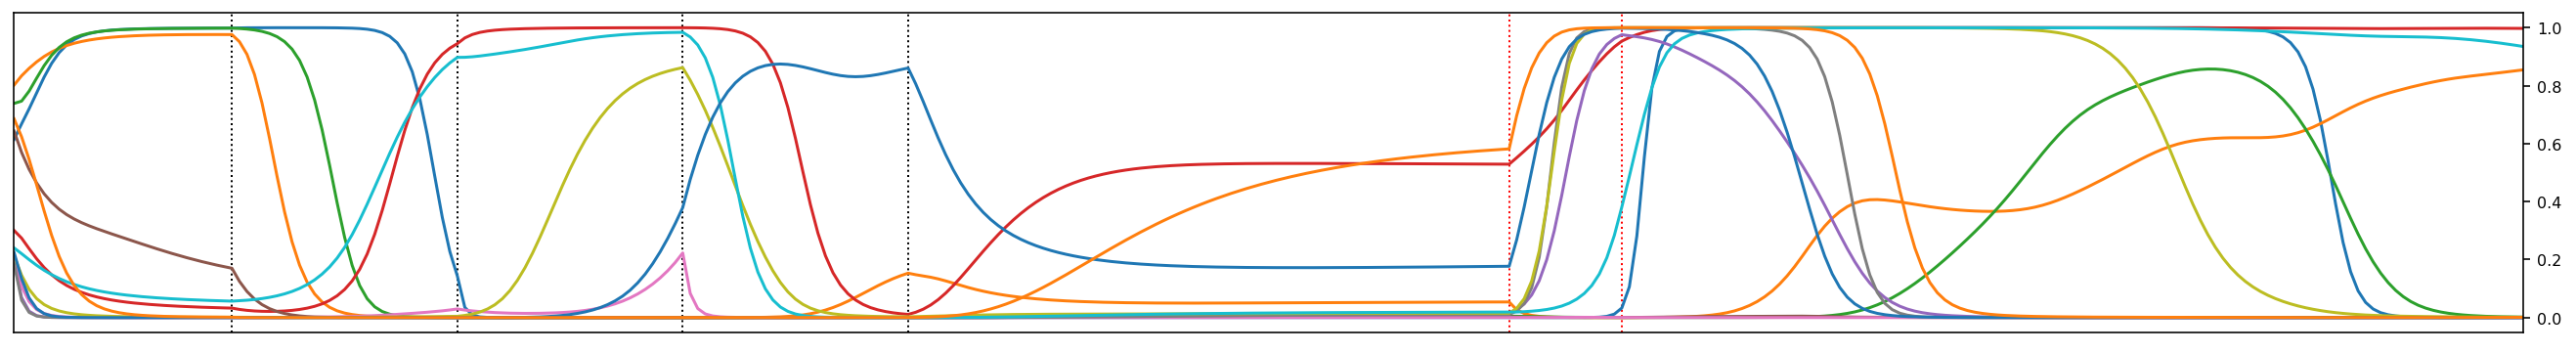

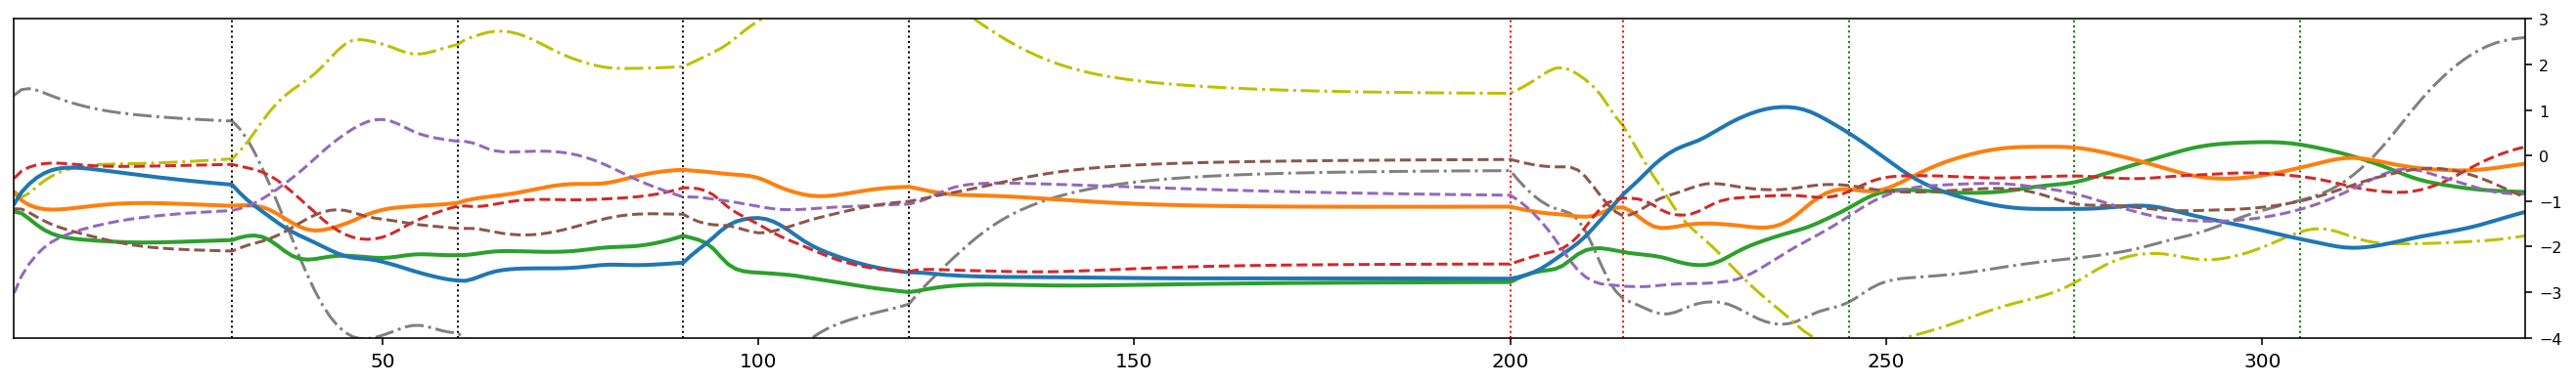

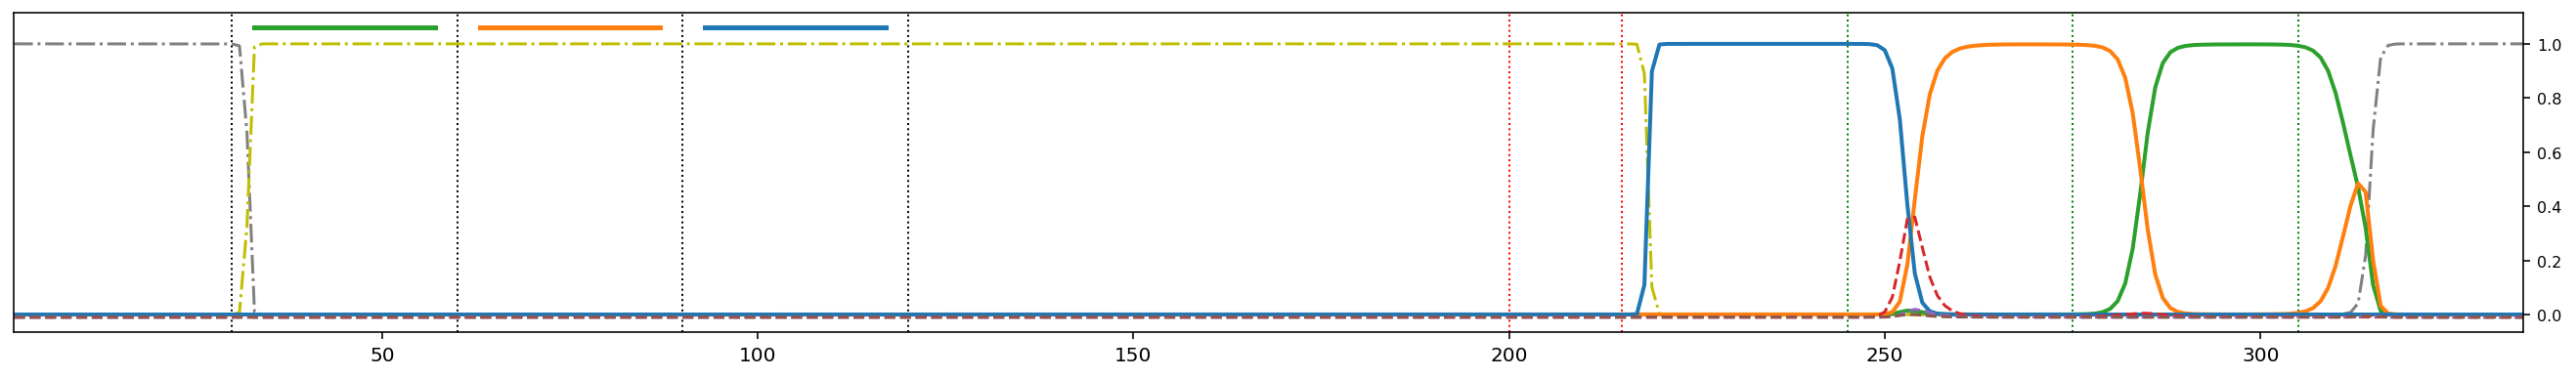

tensor([2, 1, 0]) True


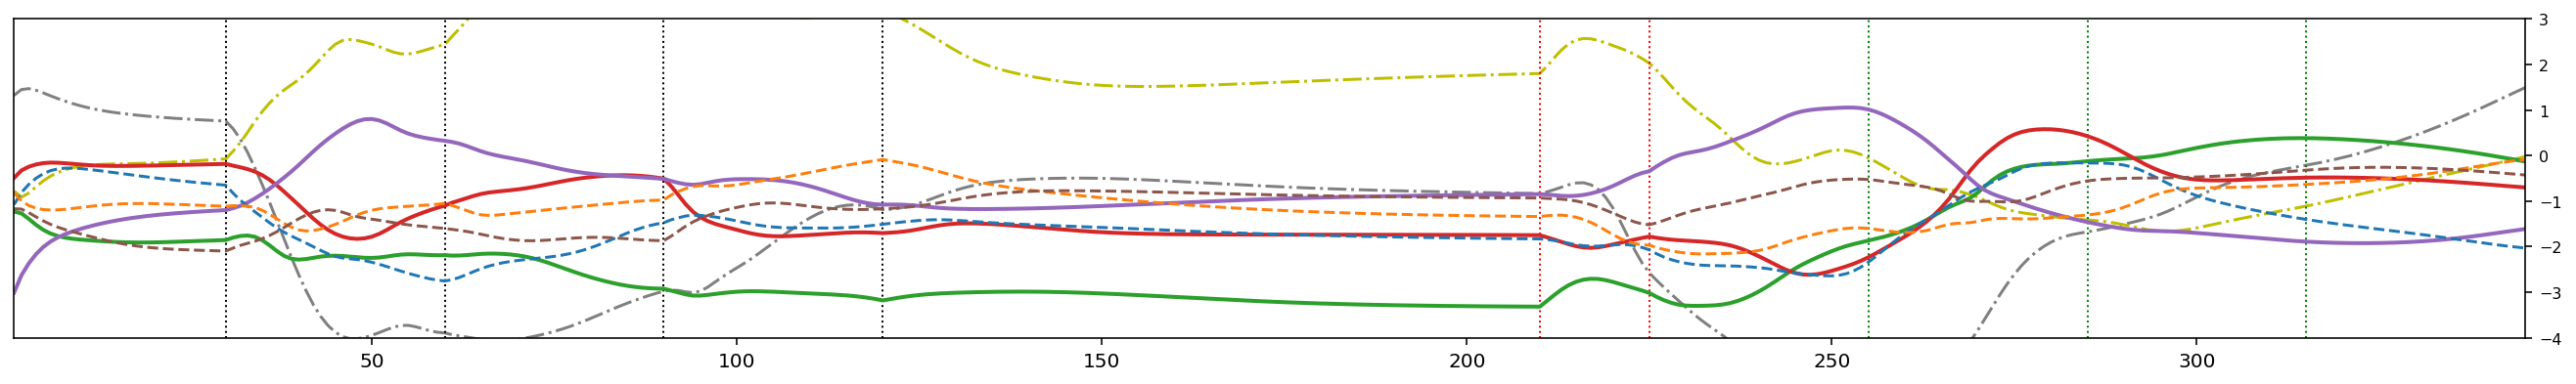

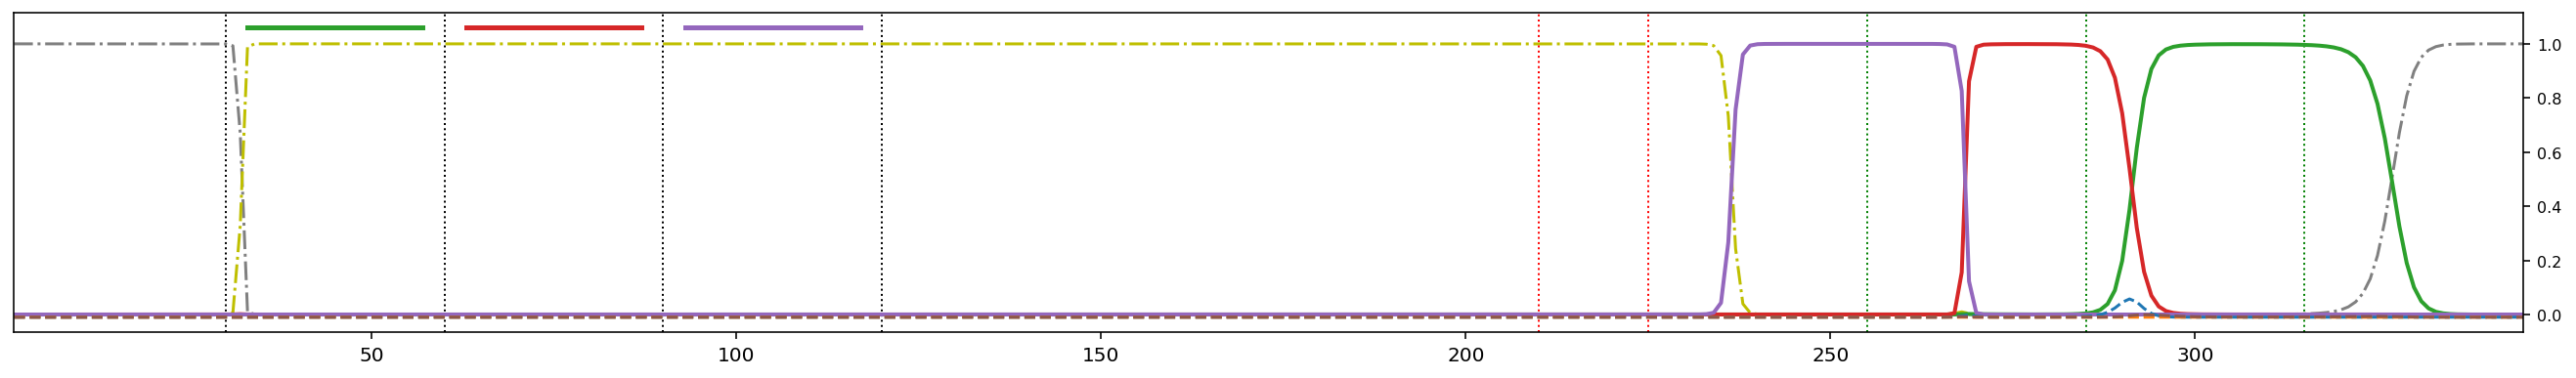

tensor([2, 3, 4]) True


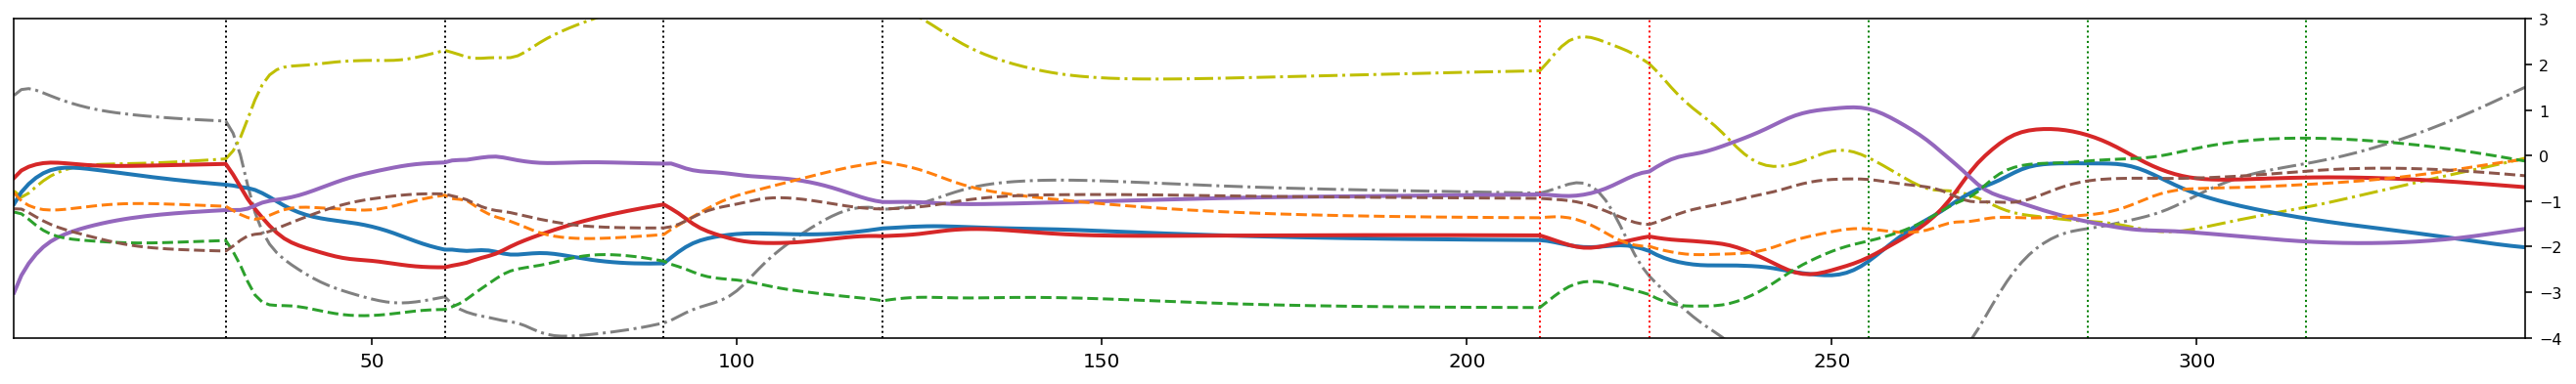

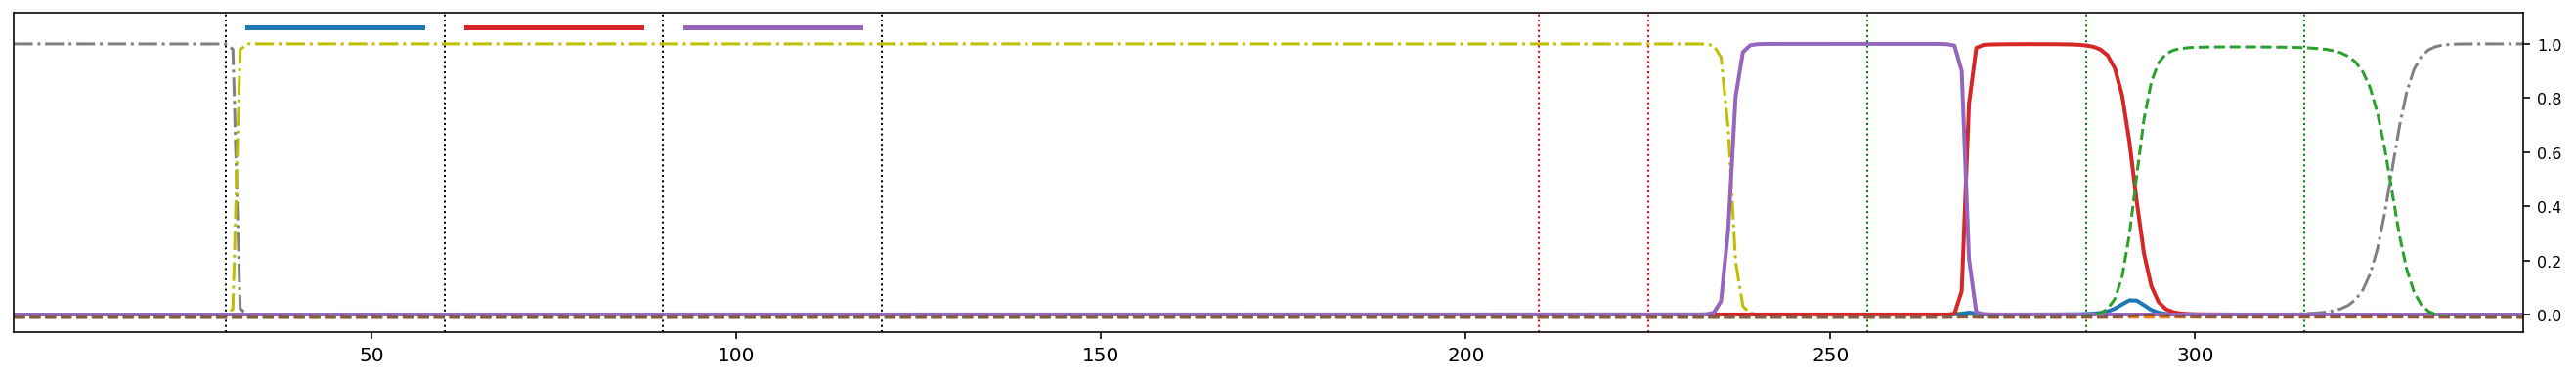

tensor([0, 3, 4]) False


In [161]:
def pTCA(X,pid=[]):
    X1 = X.factors[0]; X2 = X.factors[1]; X3 = X.factors[2]
    if len(pid)==0: pid = np.argsort(np.argmax(X2,0))
    pcol = 3; prow = len(pid); pf(24,1.5*prow)
    gs = gridspec.GridSpec(prow, pcol, width_ratios=[X2.shape[0]/80, X3.shape[0]/10, X1.shape[0]/50]); 
    gs.update(wspace=0.05,hspace=0.05)
    for ir in range(prow):
        i = pid[ir]; nx1=nm(X1[:,i]); nx2 = max(X2[:,i])
        plt.subplot(gs[ir,-1])
        xR = np.arange(1,X1.shape[0]+1)
        plt.bar(xR,X1[:,i]/nx1); plt.axhline(.2,c='C4',ls=':',lw=1)
        plt.ylim(0,.35); plt.yticks([],[])
        plt.xlim(xR[0]-1,xR[-1]+1); plt.gca().yaxis.tick_right()  
        if ir<(prow-1): plt.xticks([],[])

        plt.subplot(gs[ir,0])
        xR = np.arange(1,X2.shape[0]+1)
        plt.plot(xR,X2[:,i]/nx2,c='C1')
        plt.axhline(0,ls=':',lw=1,c='k')
        for j in range(sl+1):
            plt.axvline(t_a+t_v[0]+t_p*j,ls=':',lw=1,c='b')
        plt.axvline(t_a+t_v[0]+t_p*sl+t_d+t_v[1],ls=':',lw=1,c='r')
        plt.axvline(t_a+t_v[0]+t_p*sl+t_d+t_v[1]+t_go,ls=':',lw=1,c='r')
        for j in range(sl):
            plt.axvline(t_p*sl+t_v[0]+t_v[1]+t_d+t_go+t_a*(j+2),ls=':',lw=1,c='g')
        plt.xlim(xR[0]-1,xR[-1]+1); plt.yticks([],[])
        plt.text(xR[-1]*(1.02),plt.ylim()[1],str(i),color='g')
        if ir<(prow-1): plt.xticks([],[])
        
        plt.subplot(gs[ir,1])
        xR = np.arange(1,X3.shape[0]+1)
        for j in range(pl):
            pR = np.arange(j*spL//pl,(j+1)*spL//pl)
            plt.plot(xR[pR],X3[pR,i]*nx1*nx2,'o',c=my_cmap(j/5))
        plt.plot(xR[sid[spl:]],X3[sid[spl:],i]*nx1*nx2,'s',c='w',ms=2)
        plt.axhline(0,ls=':',lw=1,c='k')
        plt.xlim(xR[0]-1,xR[-1]+1); plt.gca().yaxis.tick_right()  
        if ir<(prow-1): plt.xticks([],[])
    plt.show()

In [158]:
with torch.set_grad_enabled(False): _,x_tca = rnn(seq_pool, t_v, 1)
R = tn(rnn.f(x_tca)); tca = ttl.ncp_hals

In [159]:
Rd = 36
U = tca(R, rank=Rd, verbose=False, tol=1e-6)
V = tca(R, rank=Rd, verbose=False, tol=1e-5)
print(U.obj, V.obj)
print(ttl.kruskal_align(U.factors, V.factors, permute_U=True, permute_V=True))
# fig, ax, po = ttl.plot_factors(U.factors); ttl.plot_factors(V.factors, fig=fig); plt.show()

0.2623705123814569 0.26378505837853455
0.941950849110738


In [ ]:
pid =  np.array([15,17])-1
pTCA(pid, U)

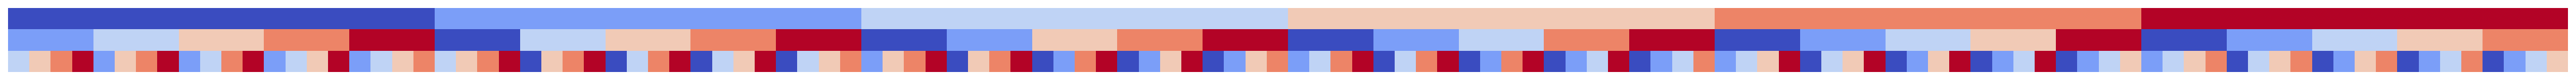

In [14]:
pf(40,8)
plt.imshow(tn(seq_pool),cmap=my_cmap)
plt.axis('off'); plt.show()# plt.yticks([],[]); plt.xticks(np.arange(spl), np.arange(1,spl+1)); 
# for i in range(spl-1): 
#     if (1+i)%6==0: color='r'
#     else: color = 'gray'
#     plt.axvline(i+.5+i/1000,c=color,lw=.75)